# Reconstruction parcimonieuse ou compressive sensing

## I. Cadre général et première tentative.

Le but du TP est de montrer que des techniques d'optimisation pour le Machine Learning permettent de récupérer des signaux qui admettent dans une certaine base une représentation parcimonieuse, c'est à dire mettant en jeu un faible nombre de coefficients. 

On s'intéresse donc à la reconstruction d'un vecteur $x$ (ici une image codées en niveaux de gris) en utilisant les valeurs de combinaisons aléatoire de certains pixels. Les combinaisons sont représentées par une matrice $\Phi$. 

Une première approche consiste à résoudre le problème $$ \min_x \frac{1}{2} ||\Phi x-y||_2^2$$ pour retrouver l'image.

**Question 1 :** Commenter et compléter le code constituant le reste de la section I.


In [2]:
using Pkg
Pkg.add("Images")
Pkg.add("Colors")
Pkg.add("LinearAlgebra")
Pkg.add("FFTW")

   Updating registry at `/applications/julia/.julia/registries/General`
┌ Warning: Some registries failed to update:
│     — `/applications/julia/.julia/registries/General` — registry dirty
└ @ Pkg.Types /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.4/Pkg/src/Types.jl:1131
  Resolving package versions...
  Installed CustomUnitRanges ────────── v1.0.2
  Installed Images ──────────────────── v0.24.1
  Installed IndirectArrays ──────────── v0.5.1
  Installed ArrayInterface ──────────── v3.1.1
  Installed ComputationalResources ──── v0.3.2
  Installed ImageFiltering ──────────── v0.6.21
  Installed Gadfly ──────────────────── v1.3.3
  Installed DualNumbers ─────────────── v0.6.5
  Installed ImageMorphology ─────────── v0.2.11
  Installed ImageDistances ──────────── v0.2.13
  Installed ColorVectorSpace ────────── v0.8.7
  Installed FFTViews ────────────────── v0.3.2
  Installed Netpbm ──────────────────── v1.0.1
  Installed CoordinateTransformations ─ v0.6.2
  Installe

┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1260
┌ Info: Precompiling ImageIO [82e4d734-157c-48bb-816b-45c225c6df19]
└ @ Base loading.jl:1260
┌ Info: Precompiling TiffImages [731e570b-9d59-4bfa-96dc-6df516fadf69]
└ @ Base loading.jl:1260
┌ Warning: `convert(Array{Gray}, img)` will soon switch to returning an array with non-concrete element type, which adds flexibility but
│ with great cost to performance. To maintain the current behavior, use `Gray.(img)` instead.
│   caller = top-level scope at In[3]:19
└ @ Core In[3]:19
┌ Info: Precompiling PNGFiles [f57f5aa1-a3ce-4bc8-8ab9-96f992907883]
└ @ Base loading.jl:1260
┌ Info: Precompiling ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1]
└ @ Base loading.jl:1260


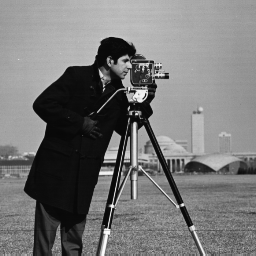

In [3]:
#
# Installation des librairies
#
#
#

#
# Repertoire ou se trouve le fichier cameraman.tif
#
#cd("$(homedir())/") 

#
# Chargement des librairies de traitement d'image
#

using Images, Colors, LinearAlgebra, FFTW

img1 = load("cameraman.tif");    # 
img=convert(Array{Gray},img1);   # 
A = convert(Array{Float64,2},img);  # 

tmp=@view img1[:,:]

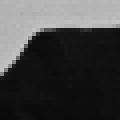

In [4]:
# Extraction d'une sous-image contrastée
k    = 30;
orig = 60;
Aloc   = A[orig:orig+k-1,orig:orig+k-1];
x   = (Aloc[:]);
n   = length(x);
m   = 500; 
Phi = randn(m,n);

imhsv=colorview(Gray,float(Aloc));
tmp=@view imhsv[:,:]

#
# Fin Extraction
#


**Question 2 :** Résoudre le problème de moindres carrés $$\min_x || \Phi x -y ||_2,$$ et afficher le résultat (attention, l'image doit être en niveaux de gris). Que constate-t-on?

248.62303637231005
11.625991564635235

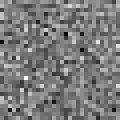

In [31]:
y     = Phi*x ; # Vecteur des "observations" de l'image
## A compléter
result = inv(transpose(Phi)*Phi)*transpose(Phi)*y;
result = (result.-minimum(result))/(maximum(result)-minimum(result))
image_result = reshape(result,k,k)
residu = norm(Phi*result-y,2)
println(residu)
imhsv_result=colorview(Gray,float(image_result));
print(norm(image_result[:].-x))
tmp=@view imhsv_result[:,:]
## Fin à compléter

#### II. Compressive sensing


On désire utiliser à présent la transformation discrète en cosinus pour obtenir une représentaiton parcimonieuse d'une image. Cette transfomation bijective est obtenue avec la fonction `dct`, son inverse s'appelant `idct`.

A partir de la fonction IDCT de Julia, on calcule la matrice  $\Theta = \Phi*\Psi$, avec $\Psi$ la matrice représentative de IDCT dans la base canonique.


In [8]:
Theta = zeros(m,n);
for ii = 1:n
    ii
    ek = zeros(1,n);
    ek[ii] = 1;
    psi = idct(ek)';
    Theta[:,ii] = Phi*psi;
end

### II.1. Utilisation d'un algorithme de sous-gradient

**Qestion 3 :** Soit $\lambda > 0$ (ici $\lambda=100$). Expliquer l'intérêt de 
 calculer $x_{sg}= \Psi z$ où $z$ résout $$\min_z \frac{1}{2} ||\Phi  \cdot \Psi  \cdot z -y||_2^2+ \lambda ||z||_1.$$ 
 
**Qestion 4 :** Justifier la convexité de la fonctionnelle et donner son sous-différentiel.

**Qestion 5 :** Compléter ci-dessous le code de sous-gradient projeté. Vous considèrerez les différents choix de pas $\alpha_i$ vus en cours, et trouverez des réglages permettant d'obtenir un bon rendu visuel. On pourra se rappeler du fait que la solution de norme minimale a une norme inférieure à dix.


In [9]:
function sou_gradient_1(z,alpha)
    n = length(z)
    somme = zeros(n,1)
    for i=1:n
        ek = zeros(n,1);
        ek[i] = 1;
        if (z[i] > 0)
            somme = somme .+ ek
        elseif(z[i] < 0)
            somme = somme .- ek
        else
            somme = somme .+ alpha *ek
        end
    end
    return somme
end

sou_gradient_1 (generic function with 1 method)

residu : 48.824082492482425
norm de z : 10.696327904375405

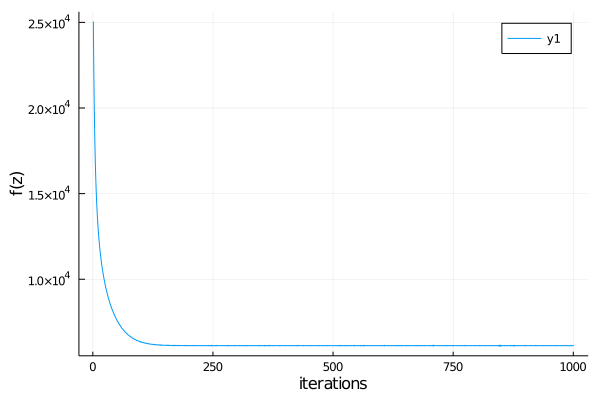

In [113]:
using Plots
z = zeros(k^2,1); i=0; lambda=100; alpha=0; nbiters = 1000;
les_fs = zeros(nbiters+1,1);
f(t) = 1/2*norm(Theta*t-y)^2 + lambda*norm(t,1) 
g = Theta'*(Theta*z - y)+lambda*sign.(z)
choix_pas = 10^-4; # 1 cas a, 2 cas b, 3 cas c
z_new = z - choix_pas*g
les_fs[1] = f(z_new);
while (i <= nbiters)
    i = i + 1;
    ## A compléter
    z = [j for j in z_new]
    g = Theta'*(Theta*z - y)+lambda*sign.(z)
    choix_pas = 10^-4; 
    z_new = z - choix_pas*g
    les_fs[i] = f(z_new);
    ## fin à compléter
end
println("residu : ",norm(Theta*z_new-y))
norm(Theta\y)
z = z_new;
print("norm de z : ",norm(z))
plot([i for i = 1:(nbiters+1)],les_fs,xlabel = "iterations",ylabel = "f(z)")

**Question 6 :** Expliquer le code suivant et conclure sur l'utilisation du sous-gradient

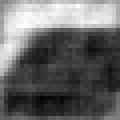

In [114]:
function my_function(n,k,z)
    x2 = zeros(n,1);
    for ii = 1:n
        ii
        ek = zeros(1,n);
        ek[ii] = 1;
        psi = idct(ek)';
        x2 = x2+psi*z[ii];
    end
    x2 = reshape(x2,k,k);
    x2 = 1/(maximum(x2).-minimum(x2))*(x2.-minimum(x2));
    return x2
end
#
x2 = my_function(n,k,z);
imhsv = colorview(Gray, float(x2));
tmp=@view imhsv[:,:]

# II.2. Utilisation d'un algorithme de sous-gradient projeté


**Question 7 :**  Expliquer l'intérêt de 
 calculer $x_{sgp}= \Psi z$ où $z$ résout $$\min_{\Phi  \cdot \Psi  \cdot z =y}  ||z||_1.$$

**Question 8 :** Rappeler la formule de la projection sur le convexe $\{x, \Phi  \cdot \Psi  \cdot z =y \}$ vue en cours.

**Question 9 :** Résoudre ce problème par l'algorithme de sous-gradient projeté et finaliser le calcul de la solution.

In [99]:
function progection(z,A,b)
    m,n = size(A)
    projete = [i for i in z]
    colonne = [A[1,j] for j in 1:n]
    ligne = transpose(colonne)
    produit = ligne*projete
    projete_new = projete .- (produit[1]-b[1])./(norm(colonne)^2).*colonne
    for i=2:m
        projete = [j for j in projete_new]
        colonne = [A[i,j] for j in 1:n]
        ligne = transpose(colonne)
        produit = ligne*projete
        projete_new = projete .- (produit[1]-b[i])./(norm(colonne)^2).*colonne
    end
    return projete_new
end     

progection (generic function with 1 method)

In [100]:
function progection2(z,alpha,pas,Theta)
    n = length(z)
    I = zeros(n,n)
    for i = 1:n
        I[i,i] = 1;
    end
    cons = pas*(I .- Theta'*inv(Theta*Theta')*Theta)
    projete = [i for i in z]
    projete_new = projete .- cons*sign.(projete)
    return projete_new
end     

progection2 (generic function with 1 method)

In [1]:
z = zeros(k^2,1); 
i=0;
alpha = 1;nbiters = 1000;
les_fs = zeros(nbiters+1,1);
##Initialisation (possible)
## A compléter

f(t) = norm(t,1) 
g = sign.(z)
choix_pas = 1; # 1 cas a, 2 cas b, 3 cas c
z_new = progection(z - choix_pas*g,Theta,y)
#z_new = progection2(z,alpha,choix_pas,Theta)
## Fin à compléter

while i <= nbiters
    i = i + 1; 
    ## A compléter
    z = [j for j in z_new]
    g = sign.(z)
    choix_pas = 1/sqrt(i); # 1 cas a, 2 cas b, 3 cas c
    z_new = progection(z - choix_pas*g,Theta,y)
    les_fs[i] = f(z_new);
    #z_new = progection2(z,alpha,choix_pas,Theta)
    ## Fin à compléter
end
println(norm(Theta*z_new-y))
norm(Theta\y)
z = z_new;
print(norm(z))
plot([i for i = 1:(nbiters+1)],les_fs,xlabel = "iterations",ylabel = "f(z)")

UndefVarError: [91mUndefVarError: k not defined[39m

4.501560899621403

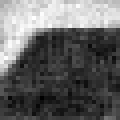

In [110]:
x3 = my_function(n,k,z);
imhsv = colorview(Gray,float(x3));
print(norm(x3[:].-x))
tmp =@view imhsv[:,:]